In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [16]:
# annotation_file = Path("./birdclef-2022/train_metadata.csv")
annotation_file = Path("./train_folds.csv")

data_dir = Path("./birdclef-2022/spectograms/")

dataframe = pd.read_csv(annotation_file)
dataframe.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,file_path,kfold
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,birdclef-2022/train_audio/afrsil1/XC125458.ogg,0
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,birdclef-2022/train_audio/afrsil1/XC175522.ogg,0
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,birdclef-2022/train_audio/afrsil1/XC177993.ogg,1
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,birdclef-2022/train_audio/afrsil1/XC205893.ogg,4
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,birdclef-2022/train_audio/afrsil1/XC207431.ogg,4


## loading data

In [88]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, data_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = data_dir / (self.labels.iloc[idx].filename[:-4] + ".npy")
        spect = np.load(img_path).swapaxes(0,1).swapaxes(1,2)
        label = self.labels.iloc[idx].primary_label
        if self.transform:
            spect = self.transform(spect)
        if self.target_transform:
            label = self.target_transform(label)
        return spect, label

In [89]:
dataset = CustomDataset(
    annotations_file = annotation_file,
    data_dir = data_dir,
    transform = transforms.ToTensor(),
)

In [90]:
len(dataset) * 0.8, len(dataset)

(11881.6, 14852)

In [91]:
train_set, val_set = torch.utils.data.random_split(dataset, [11881, 2971], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_set, batch_size=32)
val_dataloader = DataLoader(val_set, batch_size=32)

Feature batch shape: torch.Size([32, 224, 313, 3])
Labels batch shape: 32


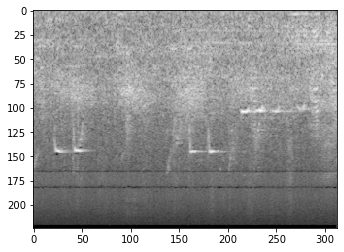

Label: houspa


In [94]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[8].squeeze()
label = train_labels[8]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model architecture

In [86]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [87]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [95]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

# preprocess a 5-second chunk
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
ntoken = train_features.size()[1]
d_model = train_features.size()[2]

n_classes = len(dataframe.primary_label.unique())
d_hid = 200 # dimension of the feed-forward network model in nn.TransformerEncoder
nlayers = 1 # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 1 # number of heads in nn.MultiheadAttention
dropout = 0.2 # dropout probability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(ntoken =  ntoken,
                        d_model = d_model,
                        nhead = nhead,
                        d_hid = d_hid,
                        nlayers = nlayers).to(device)
model

Feature batch shape: torch.Size([32, 224, 313, 3])


RuntimeError: The expanded size of the tensor (156) must match the existing size (157) at non-singleton dimension 1.  Target sizes: [5000, 156].  Tensor sizes: [5000, 157]

In [ ]:
f1score = f1_score(y_test, np.round(preds), average="micro")
print(f1score)

In [ ]:
birdclef_dir = "/kaggle/input/birdclef-2022/"

with open(birdclef_dir + "scored_birds.json") as fp:
    scored_birds = json.load(fp)
    
print(scored_birds)

In [ ]:
def eval_test_file(filedir, filename):
    data = []
    audio, sample_rate = librosa.load(filedir + filename)
    num_chunks = math.ceil(len(audio) / (sample_rate * 5))
    for chunk in range(num_chunks):
        starting_second = chunk * 5
        ending_second = (chunk + 1) * 5
        audio_chunk = audio[(sample_rate * starting_second):(sample_rate * ending_second)]
        pred = round(xg_reg.predict([audio_chunk])[0])
        bird_id = le.inverse_transform([pred])[0]
        for bird in scored_birds:
            row_id = filename[:-4] + "_" + bird + "_" + str(ending_second)
            result = bird == bird_id
            data.append((row_id, result))
    return data

test_data_path = birdclef_dir + "test_soundscapes/"
out = eval_test_file(test_data_path, "soundscape_453028782.ogg")
out_df = pd.DataFrame(out, columns=["row_id","result"])
out_df.head()

In [ ]:
test_data_path = birdclef_dir + "test_soundscapes/"
filenames = sorted(os.listdir(test_data_path))
data = []
for filename in filenames:
    data += eval_test_file(test_data_path, filename)
test_df = pd.DataFrame(sorted(data), columns=['row_id', 'result'])
test_df.to_csv("submission.csv", index=False)